In [1]:
import Curve
import SimuCurve
import SimuFXSpot
import HW
import Swap
import FXForward
import numpy as np
import datetime as dt
import CashFlow
import math
import matplotlib.pyplot as plt

In [2]:
def build_cva_models(model_map, val_date, num_path, simu_dates, irs_curve, dom_curve, for_curve, fx_spot):
    '''
    build HW model for rate and FX GBM model for fx
    :param model_map: output, models are saved here
    :param val_date:
    :param num_path:  the number of simulation path
    :param simu_dates:  simulation dates, actually in year fraction
    :param irs_curve:   input curve for hw model, for swap valuation
    :param dom_curve:   input curve for hw model, for fx model domestic rate
    :param for_curve:   input curve for hw model, for fx model foreign rate
    :param fx_spot:     today's fx spot rate
    :return:
    '''
    if irs_curve is not None:
        initial_short_rate = irs_curve.get_zero_rate(0)
        mr = 0.1
        vol = 0.01
        hw_model = HW.HullWhite(val_date, mr, vol, num_path, simu_dates, initial_short_rate)
        irs_simu_curve = SimuCurve.simucurve(irs_curve, hw_model)
        model_map['irs_simu_curve'] = irs_simu_curve

    # construct 3 models for fx simulation: dom_simu_curve, for_simu_curve, simu_fx_spot
    if dom_curve is not None and for_curve is not None and fx_spot is not None:
        initial_short_rate = dom_curve.get_zero_rate(0)
        mr = 0.1
        vol = 0.01
        dom_hw_model = HW.HullWhite(val_date, mr, vol, num_path, simu_dates, initial_short_rate)
        dom_simu_curve = SimuCurve.simucurve(dom_curve, dom_hw_model)
        model_map['dom_simu_curve'] = dom_simu_curve

        initial_short_rate = for_curve.get_zero_rate(0)
        mr = 0.1
        vol = 0.01
        for_hw_model = HW.HullWhite(val_date, mr, vol, num_path, simu_dates, initial_short_rate)
        for_simu_curve = SimuCurve.simucurve(for_curve, for_hw_model)
        model_map['for_simu_curve'] = for_simu_curve

        fx_vol = 0.1
        simu_fx_spot = SimuFXSpot.simufxspot(fx_spot, fx_vol, simu_dates, dom_simu_curve, for_simu_curve)
        model_map['simu_fx_spot'] = simu_fx_spot

In [3]:
def compute_exposure_matrix(exposure_matrix, trade, model_map, simu_dates, num_path, corr_matrix, is_discounted=True):
    '''
    the exposure matrix computation, calculate mtm on each path and each simulation date
    :param exposure_matrix: output, numpy array, size the number of simulation dates * the number of path
    :param trade: currently supports interest rate swap and fx forward
    :param model_map:
    :param simu_dates:
    :param num_path:
    :param corr_matrix: for FX model, we simulate 3 models, this the correlation of brownian motions
    :param is_discounted: true for EDPE, false for EPE (mainly for debugging purpose)
    :return:
    '''
    fwd_rate = 0
    running_dfs = np.ones(num_path)
    for i in range(0, simu_dates.shape[0]):
        # step 1 generate correalted random number:
        if len(model_map) == 1:
            rns = np.random.normal(0, 1, num_path)
        else:
            rns = np.random.multivariate_normal(np.zeros(len(model_map)), corr_matrix, num_path)

        # step 2 evolve model and simulate short rates and fxspot
        model_count = 0
        for key, item in model_map.items():
            # hw model
            if key.find('curve') > -1:
                if i == 0:
                    fwd_rate = item.curve.get_zero_rate(0)
                else:
                    current_slice_date = item.hw_model.get_current_simu_date()
                    prev_slice_date = item.hw_model.get_prev_simu_date()
                    fwd_rate = -(math.log(item.curve.get_discount_factor(current_slice_date))
                                 - math.log(item.curve.get_discount_factor(prev_slice_date))) / (current_slice_date - prev_slice_date)
                current_model_rns = rns
                if len(model_map) > 1:
                    current_model_rns = rns[:,model_count]
                item.hw_model.compute_short_rate(fwd_rate, current_model_rns)
            if key.find('fx_spot') > -1:
                if len(model_map) < 3:
                    raise ValueError('fx model has depdence on rates model, rates model can not be empty')
                item.simulate_fx_spot(rns[:,model_count])
            model_count += 1
        # step 3 compute mtm per slice and get exposure matrix
        trade.set_simulation_date(simu_dates[i])
        if isinstance(trade, Swap.swap) and is_discounted:
            running_dfs = model_map['irs_simu_curve'].get_running_dfs()
        if isinstance(trade, FXForward.fxforward) and is_discounted:
            running_dfs = model_map['dom_simu_curve'].get_running_dfs()
        exposure_matrix[i] = trade.compute_mtm() * running_dfs
        # move simulation index to next slice
        for item in model_map.values():
            item.move_to_next_slice()

In [4]:
def compute_exposure_metric(EDPE, EDNE, EDFV, exposure_matrix):
    '''
    compute common risk metric for XVA
    :param EDPE: output, expect discounted positive exposure
    :param EDNE: output, expect discounted negative exposure
    :param EDFV: output, expect discounted future exposure
    :param exposure_matrix: input
    :return:
    '''
    num_of_path = exposure_matrix.shape[1]
    for i in range(0, exposure_matrix.shape[0]):
        currrent_exposure = exposure_matrix[i]
        EDPE[i] = currrent_exposure[currrent_exposure>0].sum() / num_of_path
        EDNE[i] = currrent_exposure[currrent_exposure<0].sum() / num_of_path
        EDFV[i] = currrent_exposure.mean()

In [5]:
val_date = dt.datetime(2020, 1, 2)
num_path = 5000
simu_dates = np.array([0.05 * xx for xx in range(0, 100)])
# 1.1 curves for fx forward and fx spot: dom_curve, for_curve, fx_spot
x = np.array([0.25, 0.5, 1, 2, 3, 5, 7, 10, 20])
dom_y = np.array([0.035, 0.035, 0.035, 0.035, 0.035, 0.035, 0.035, 0.035, 0.035])
for_y = np.array([0.0175, 0.0175, 0.0175, 0.0175, 0.0175, 0.0175, 0.0175, 0.0175, 0.0175])
dom_curve = Curve.curve("dom curve", val_date, x, dom_y)
for_curve = Curve.curve("for curve", val_date, x, for_y)
fx_spot = 100

# step 2 build simulation models, HW for rate and GBM for fx
# correlation matrix between 2 rates and fx spot: corr_matrix, 3*3 numpy array
model_map = {}
build_cva_models(model_map, val_date, num_path, simu_dates, None, dom_curve, for_curve, fx_spot)
# corr_matrix = np.identity(3)
# corr_matrix = np.array([[1, 0.5, -0.5], [0.5, 1, 0.5], [-0.5, 0.5, 1]])
corr_matrix = np.array([[1, -0.5, 0.5], [-0.5, 1, -0.5], [0.5, -0.5, 1]])

# step 3 compute exposure matrix, numpy array size number of simulation dates * number of simulation path
# compute exposure metric, EDPE, EDNE, EDFV, vector number of simulation dates * 1
exposure_matrix = np.zeros([simu_dates.shape[0], num_path])
EDPE = np.zeros(simu_dates.shape[0])
EDNE = np.zeros(simu_dates.shape[0])
EDFV = np.zeros(simu_dates.shape[0])
fx_forward = FXForward.fxforward(val_date, '5Y', 109.144226, 1.,
                            model_map['simu_fx_spot'], model_map['dom_simu_curve'], model_map['for_simu_curve'])
compute_exposure_matrix(exposure_matrix, fx_forward, model_map, simu_dates, num_path, corr_matrix)
compute_exposure_metric(EDPE, EDNE, EDFV, exposure_matrix)

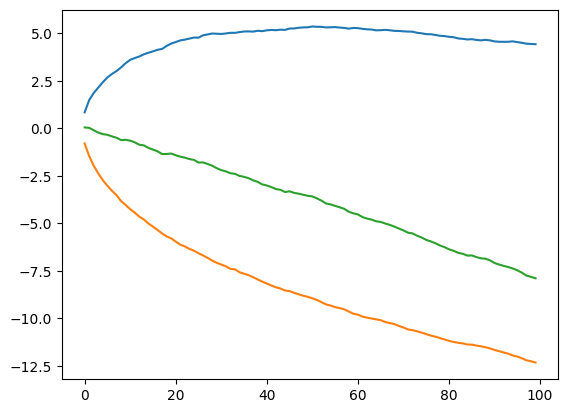

In [6]:
plt.plot(EDPE)
plt.plot(EDNE)
plt.plot(EDFV)

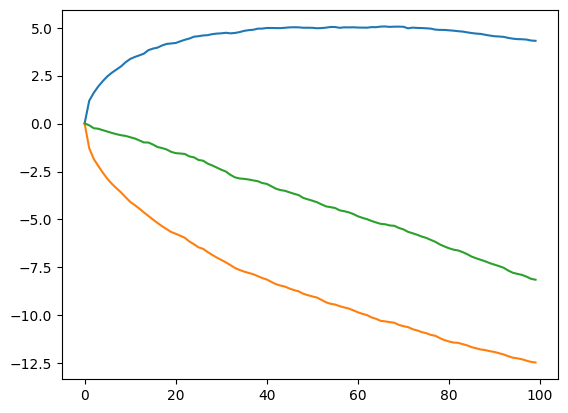

In [19]:
plt.plot(EDPE)
plt.plot(EDNE)
plt.plot(EDFV)

In [7]:
val_date = dt.datetime(2020, 1, 2)
num_path = 5000
simu_dates = np.array([(xx - val_date).days / 365. for xx in CashFlow.month_range_day(val_date, 41, '3M')])
# 1.1 test curve for interest swap
x = np.array([0.25, 0.5, 1, 2, 3, 5, 7, 10, 20])
y = np.array([0.008, 0.0085, 0.0092, 0.01, 0.0106, 0.0119, 0.0132, 0.015, 0.02])
irs_curve = Curve.curve("curve", val_date, x, y)

# step 2 build simulation models, HW for rate and GBM for fx
model_map = {}
build_cva_models(model_map, val_date, num_path, simu_dates, irs_curve, None, None, None)

# step 3 compute exposure matrix, numpy array size number of simulation dates * number of simulation path
# compute exposure metric, EDPE, EDNE, EDFV, vector number of simulation dates * 1
exposure_matrix = np.zeros([simu_dates.shape[0], num_path])
EDPE = np.zeros(simu_dates.shape[0])
EDNE = np.zeros(simu_dates.shape[0])
EDFV = np.zeros(simu_dates.shape[0])
vanilla_swap = Swap.swap(val_date, '10Y', '3M', '3M', False, 0.015, -1,
                            model_map['irs_simu_curve'], None, model_map['irs_simu_curve'], model_map['irs_simu_curve'])
compute_exposure_matrix(exposure_matrix, vanilla_swap, model_map, simu_dates, num_path, None)
compute_exposure_metric(EDPE, EDNE, EDFV, exposure_matrix)

e:\Github\NTUsg\FN6814-Financial-Risk-Management\CVA_Students\CashFlow.py:13: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  month_range = pd.date_range(start=start_date, periods=periods, freq=month_freq)
e:\Github\NTUsg\FN6814-Financial-Risk-Management\CVA_Students\CashFlow.py:13: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  month_range = pd.date_range(start=start_date, periods=periods, freq=month_freq)
e:\Github\NTUsg\FN6814-Financial-Risk-Management\CVA_Students\CashFlow.py:13: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  month_range = pd.date_range(start=start_date, periods=periods, freq=month_freq)
e:\Github\NTUsg\FN6814-Financial-Risk-Management\CVA_Students\CashFlow.py:13: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  month_range = pd.date_range(start=start_date

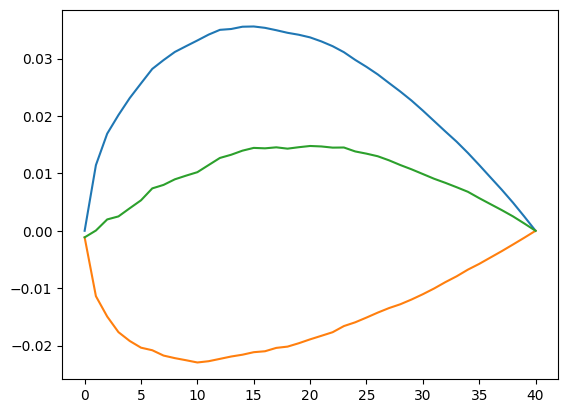

In [8]:
plt.plot(EDPE)
plt.plot(EDNE)
plt.plot(EDFV)

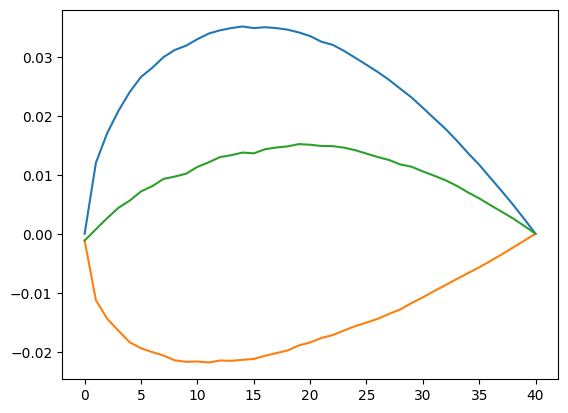

In [22]:
plt.plot(EDPE)
plt.plot(EDNE)
plt.plot(EDFV)

In [23]:
# step 4, compute CVA and FBA, FCA
results_dict = {}
x = np.array([1, 3, 5, 7, 10, 20])
y = np.array([0.0018, 0.001, 0.0092, 0.012, 0.0135, 0.0142])
cpty_credit_curve = Curve.curve("curve", val_date, x, y)
y = np.array([0.0008, 0.00135, 0.0033, 0.00525, 0.00675, 0.00735])
own_credit_curve = Curve.curve("curve", val_date, x, y)
LGD = 0.6
own_LGD = 0.6
borowing_funding_spread = np.array([0.00075, 0.00135, 0.0033, 0.00525, 0.00675, 0.00735])
borrowing_fs_curve = Curve.curve("curve", val_date, x, borowing_funding_spread)
lending_funding_spread = np.array([0.000375, 0.000675, 0.00165, 0.002625, 0.003375, 0.003675])
lending_fs_curve = Curve.curve("curve", val_date, x, lending_funding_spread)

# compute_xva(results_dict, simu_dates, EDPE, EDNE, cpty_credit_curve, own_credit_curve,
#             borrowing_fs_curve, lending_fs_curve, LGD, own_LGD)

In [24]:
def compute_xva(results_dict, simu_dates, EDPE, EDNE, cpty_credit_curve, own_credit_curve,
            borrowing_fs_curve, lending_fs_curve, LGD, own_LGD):
    pass
    